In [62]:
import string
import re
from os import listdir
from numpy import array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten, Dropout
from keras.layers import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Input
from keras.layers import Embedding
from keras.layers.merge import concatenate
from keras.models import Model

In [47]:
#loading file
def load_doc(filename):
    file = open(filename,'r')
    text = file.read()
    file.close()
    return text

we will prepare the data using the following method:

 Split tokens on white space.

 Remove all punctuation from words.

 Remove all words that are not purely comprised of alphabetical characters.

 Remove all words that are known stop words.

 Remove all words that have a length <= 1 character.

In [48]:
#turning a doc into clean tokens
def clean_doc(doc):
    tokens = doc.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    #remove punctuation
    token = [re_punc.sub(' ',w) for w in tokens]
    tokens = [word for word in tokens if word.isalpha()]
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    tokens = [w for w in tokens if len(w)>1]
    return tokens

In [49]:
#creating tokens on a single file
neg = load_doc('txt_sentoken/pos/cv000_29590.txt') 
token = clean_doc(neg)
print(token)

['films', 'adapted', 'comic', 'books', 'plenty', 'success', 'whether', 'superheroes', 'batman', 'superman', 'spawn', 'geared', 'toward', 'kids', 'casper', 'arthouse', 'crowd', 'ghost', 'world', 'never', 'really', 'comic', 'book', 'like', 'hell', 'starters', 'created', 'alan', 'moore', 'eddie', 'campbell', 'brought', 'medium', 'whole', 'new', 'level', 'mid', 'series', 'called', 'watchmen', 'say', 'moore', 'campbell', 'thoroughly', 'researched', 'subject', 'jack', 'ripper', 'would', 'like', 'saying', 'michael', 'jackson', 'starting', 'look', 'little', 'odd', 'book', 'graphic', 'novel', 'pages', 'long', 'includes', 'nearly', 'consist', 'nothing', 'footnotes', 'words', 'dismiss', 'film', 'source', 'get', 'past', 'whole', 'comic', 'book', 'thing', 'might', 'find', 'another', 'stumbling', 'block', 'directors', 'albert', 'allen', 'hughes', 'getting', 'hughes', 'brothers', 'direct', 'seems', 'almost', 'ludicrous', 'casting', 'carrot', 'top', 'well', 'anything', 'riddle', 'better', 'direct', 'f

##### Defining a Vocabulary

It is important to define a vocabulary of known words when using a bag-of-words model. The
more words, the larger the representation of documents, therefore it is important to constrain
the words to only those believed to be predictive. This is dicult to know beforehand and often
it is important to test different hypotheses about how to construct a useful vocabulary.

In [50]:
def add_doc_to_vocab(filename,vocab):
    doc = load_doc(filename)
    tokens = clean_doc(doc)
    vocab.update(tokens)

In [51]:
def process_docs(directory,vocab):
    for filename in listdir(directory):
        if filename.startswith('cv9'):
            continue
        path = directory +'/'+filename
        add_doc_to_vocab(path,vocab)

In [52]:
from collections import Counter
vocab = Counter()
process_docs('txt_sentoken/pos',vocab)
process_docs('txt_sentoken/neg',vocab)

print(len(vocab))
# top 50 most common words used in the reviews
print(vocab.most_common(50))

36053
[('film', 7974), ('one', 4939), ('movie', 4815), ('like', 3193), ('even', 2261), ('good', 2073), ('time', 2039), ('story', 1899), ('would', 1843), ('much', 1823), ('also', 1757), ('get', 1723), ('character', 1699), ('two', 1642), ('characters', 1618), ('first', 1586), ('see', 1553), ('way', 1515), ('well', 1477), ('make', 1418), ('really', 1400), ('little', 1347), ('films', 1338), ('life', 1329), ('plot', 1286), ('people', 1267), ('could', 1248), ('bad', 1246), ('scene', 1240), ('never', 1197), ('best', 1176), ('new', 1139), ('scenes', 1132), ('many', 1129), ('man', 1122), ('know', 1092), ('movies', 1027), ('great', 1011), ('another', 992), ('action', 980), ('love', 975), ('us', 967), ('go', 950), ('director', 947), ('something', 944), ('end', 943), ('still', 935), ('seems', 930), ('back', 921), ('made', 911)]


In [53]:
tokens = [k for k,c in vocab.items() if c>= 2]
print(len(tokens))

23275


In [54]:
#saving token or vocab in a txt file
data = '\n'.join(tokens)
file = open('vocab.txt','w')
file.write(data)
file.close()

In [55]:
#load the vocubulary 
vocab_file = 'vocab.txt'
vocab = load_doc(vocab_file)
vocab = set(vocab.split())
len(vocab)

23275

##### Bag of Words

any information about the order or structure of words in the document is discarded. The model is only concerned with whether known words occur in the document, not where in the document. The intuition is that documents are similar if they have similar content. As the vocabulary size increases, so does the vector representation of documents.

A more sophisticated approach is to create a vocabulary of grouped words. This both changes the scope of the vocabulary and allows the bag-of-words to capture a little bit more meaning from the document. In this approach, each word or token is called a gram. Creating a vocabulary of two-word pairs is, in turn, called a bigram model. Again, only the bigrams that appear in the corpus are modeled, not all possible bigrams.

In [56]:
#load doc, clean and return line of tokens()
def doc_to_line(filename,vocab):
    doc = load_doc(filename)
    tokens = clean_doc(doc)
    tokens = [w for w in tokens if w in vocab]
    return ' '.join(tokens)

In [57]:
def process_docs(directory, vocab, is_train):
    lines = list()
    # walk through all files in the folder
    for filename in listdir(directory):
        # skip any reviews in the test set
        if is_train and filename.startswith('cv9'):
            continue
        if not is_train and not filename.startswith('cv9'):
            continue
        # create the full path of the file to open
        path = directory + '/' + filename
        # load and clean the doc
        line = doc_to_line(path, vocab)
        # add to list
        lines.append(line)
    return lines

In [58]:
def load_clean_dataset(vocab,is_train):
    neg = process_docs('txt_sentoken/neg',vocab,is_train)
    pos = process_docs('txt_sentoken/pos',vocab,is_train)
    docs = neg + pos

    labels = [0 for _ in range (len(neg))] + [1 for _ in range(len(pos))]
    return docs,labels

#### Movie reviews to bag of words vector

In [59]:
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [60]:
train_docs, ytrain = load_clean_dataset(vocab,True)
test_docs, ytest = load_clean_dataset(vocab,False)

print(len(train_docs))
print(len(test_docs))

tokenizer = create_tokenizer(train_docs)

Xtrain = tokenizer.texts_to_matrix(train_docs,mode='freq')
Xtest = tokenizer.texts_to_matrix(test_docs,mode='freq')

print(Xtrain.shape , Xtest.shape)

1800
200
(1800, 23276) (200, 23276)


In [16]:
def define_model(n_words):
    model = Sequential()
    model.add(Dense(50,input_shape=(n_words,),activation='relu'))
    model.add(Dense(25,activation='relu'))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(loss='binary_crossentropy' ,optimizer='adam',metrics=['accuracy'])
    #model.summary()
    return model

In [17]:
n_words = Xtest.shape[1]
model = define_model(n_words)
model.fit(Xtrain,ytrain,epochs=10,verbose=2)

Epoch 1/10
 - 2s - loss: 0.6927 - acc: 0.5878
Epoch 2/10
 - 2s - loss: 0.6881 - acc: 0.5250
Epoch 3/10
 - 2s - loss: 0.6679 - acc: 0.7272
Epoch 4/10
 - 2s - loss: 0.6068 - acc: 0.8383
Epoch 5/10
 - 2s - loss: 0.4873 - acc: 0.9356
Epoch 6/10
 - 2s - loss: 0.3451 - acc: 0.9622
Epoch 7/10
 - 2s - loss: 0.2284 - acc: 0.9828
Epoch 8/10
 - 2s - loss: 0.1529 - acc: 0.9872
Epoch 9/10
 - 2s - loss: 0.1028 - acc: 0.9950
Epoch 10/10
 - 2s - loss: 0.0714 - acc: 0.9972


In [18]:
loss,acc = model.evaluate(Xtest,ytest,verbose=10)
print('Test Accuracy: %f' % (acc*100))

Test Accuracy: 92.000000


#### Comparing Word Scoring Models

The texts to matrix() function for the Tokenizer in the Keras API provides 4 different
methods for scoring words; they are:

 binary Where words are marked as present (1) or absent (0).

 count Where the occurrence count for each word is marked as an integer.

 tfidf Where each word is scored based on their frequency, where words that are common
across all documents are penalized.

 freq Where words are scored based on their frequency of occurrence within the document.

In [19]:
def prepare_data(train_docs, test_docs, mode):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(train_docs)
    Xtrain = tokenizer.texts_to_matrix(train_docs, mode=mode)
    Xtest = tokenizer.texts_to_matrix(test_docs, mode=mode)
    return Xtrain, Xtest

In [20]:
def evaluate_mode(Xtrain, ytrain, Xtest, ytest):
    scores = list()
    n_repeats = 10
    n_words = Xtest.shape[1]
    for i in range(n_repeats):
        # define network
        model = define_model(n_words)
        model.fit(Xtrain, ytrain, epochs=10, verbose=0)
        _, acc = model.evaluate(Xtest, ytest, verbose=0)
        scores.append(acc)
        print('%d accuracy: %s' % ((i+1), acc))
    return scores

In [21]:
from pandas import DataFrame
modes = ['binary','count','tfidf','freq']
results = DataFrame()
for mode in modes:
    print(mode)
    Xtrain,Xtest = prepare_data(train_docs,test_docs,mode)
    results[mode] = evaluate_mode(Xtrain,ytrain,Xtest,ytest)

binary
1 accuracy: 0.915
2 accuracy: 0.915
3 accuracy: 0.92
4 accuracy: 0.92
5 accuracy: 0.92
6 accuracy: 0.93
7 accuracy: 0.915
8 accuracy: 0.935
9 accuracy: 0.925
10 accuracy: 0.915
count
1 accuracy: 0.915
2 accuracy: 0.885
3 accuracy: 0.88
4 accuracy: 0.89
5 accuracy: 0.875
6 accuracy: 0.905
7 accuracy: 0.905
8 accuracy: 0.88
9 accuracy: 0.91
10 accuracy: 0.885
tfidf
1 accuracy: 0.875
2 accuracy: 0.87
3 accuracy: 0.875
4 accuracy: 0.875
5 accuracy: 0.87
6 accuracy: 0.855
7 accuracy: 0.89
8 accuracy: 0.865
9 accuracy: 0.89
10 accuracy: 0.88
freq
1 accuracy: 0.91
2 accuracy: 0.91
3 accuracy: 0.92
4 accuracy: 0.915
5 accuracy: 0.915
6 accuracy: 0.915
7 accuracy: 0.92
8 accuracy: 0.915
9 accuracy: 0.9
10 accuracy: 0.91


          binary      count      tfidf       freq
count  10.000000  10.000000  10.000000  10.000000
mean    0.921000   0.893000   0.874500   0.913000
std     0.006992   0.014376   0.010659   0.005869
min     0.915000   0.875000   0.855000   0.900000
25%     0.915000   0.881250   0.870000   0.910000
50%     0.920000   0.887500   0.875000   0.915000
75%     0.923750   0.905000   0.878750   0.915000
max     0.935000   0.915000   0.890000   0.920000


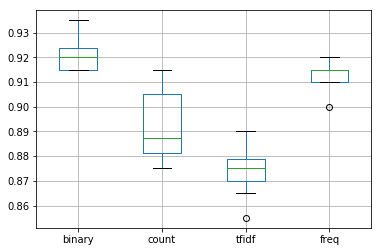

In [22]:
print(results.describe())
results.boxplot()
plt.show()

In [23]:
def predict_sentiment(review,vocab,tokenizer,model):
    tokens = clean_doc(review)
    tokens = [w for w in tokens if w in vocab]
    line = ' '.join(tokens)
    encoded = tokenizer.texts_to_matrix([line],mode='binary')
    yhat = model.predict(encoded, verbose=0)
    percent_pos = yhat[0,0]
    if round(percent_pos) == 0:
        return (1-percent_pos), 'NEGATIVE'
    return percent_pos, 'POSITIVE'

In [24]:
#choosing binary as it performing better than the other two
Xtrain = tokenizer.texts_to_matrix(train_docs, mode='binary')
Xtest = tokenizer.texts_to_matrix(test_docs, mode='binary')
# define network
n_words = Xtrain.shape[1]
model = define_model(n_words)
# fit network
model.fit(Xtrain, ytrain, epochs=10, verbose=2)

Epoch 1/10
 - 3s - loss: 0.4920 - acc: 0.7672
Epoch 2/10
 - 2s - loss: 0.0499 - acc: 0.9928
Epoch 3/10
 - 2s - loss: 0.0070 - acc: 1.0000
Epoch 4/10
 - 2s - loss: 0.0024 - acc: 1.0000
Epoch 5/10
 - 2s - loss: 0.0012 - acc: 1.0000
Epoch 6/10
 - 2s - loss: 7.2350e-04 - acc: 1.0000
Epoch 7/10
 - 2s - loss: 4.8513e-04 - acc: 1.0000
Epoch 8/10
 - 2s - loss: 3.4009e-04 - acc: 1.0000
Epoch 9/10
 - 2s - loss: 2.5307e-04 - acc: 1.0000
Epoch 10/10
 - 2s - loss: 1.9315e-04 - acc: 1.0000


In [25]:
text = 'Best movie ever! It was great, I recommend it.'
percent, sentiment = predict_sentiment(text, vocab, tokenizer, model)
print('Review: [%s]\nSentiment: %s (%.3f%%)' % (text, sentiment, percent*100))

Review: [Best movie ever! It was great, I recommend it.]
Sentiment: POSITIVE (50.421%)


In [26]:
text = 'This is a bad movie.'
percent, sentiment = predict_sentiment(text, vocab, tokenizer, model)
print('Review: [%s]\nSentiment: %s (%.3f%%)' % (text, sentiment, percent*100))

Review: [This is a bad movie.]
Sentiment: NEGATIVE (67.394%)


In [27]:
text = 'This movie wasn\'t worth watching.'
percent, sentiment = predict_sentiment(text, vocab, tokenizer, model)
print('Review: [%s]\nSentiment: %s (%.3f%%)' % (text, sentiment, percent*100))

Review: [This movie wasn't worth watching.]
Sentiment: NEGATIVE (54.018%)
